# Alternatives to SEG-Y
*by [Alan Richardson](mailto:alan@ausargeo.com) ([Ausar Geophysical](http://www.ausargeo.com))*

SEG-Y and its problems are well known. Matt Hall wrote [a short piece about both](https://agilescientific.com/blog/2014/3/26/what-is-seg-y.html) in 2014, and there was also [a question on Earth Science Stack Exchange](https://earthscience.stackexchange.com/questions/694/what-would-a-replacement-for-segy-look-like) in the same year discussing ideas for a replacement. A few years have passed, but I don't feel like much progress has been made in moving exploration seismology to a better file format. I am thus raising the topic again, with a review of the arguments and alternatives, and a demonstration of what a move to NetCDF would enable.

## The problems with SEG-Y

SEG-Y has shown impressive longevity. It has been more than forty years since the initial release. A lot has changed even since "rev 1" in 2002, yet SEG-Y still completely dominates the exchange of reflection seismic data. Such endurance is no doubt due to good design decisions when the format was conceived. What was appropriate in 2002 is, however, not necessarily what is still the best way to store data today. In fact, there are, in my opinion, several problems with SEG-Y that make me wish everyone would start using something else.

The principal of these is its relatively small userbase. It can feel like there are a lot of people involved in the exploration seismology field when confronted with the thousands of attendees at SEG, and there is (even now) quite a bit of money to support developments. Yet, compared to other formats, such as HDF5, [interest in SEG-Y is insignificant](https://trends.google.com/trends/explore?q=seg-y%20OR%20segy,%2Fm%2F02z2yy). As a result, there are few tools and libraries that support SEG-Y. This makes it more difficult to work with. Do the benefits of having our own, unique format really warrant that much frustration?

SEG-Y also lacks an awareness of the need for flexibility. There are (pre-"rev 2") a fixed number of bytes for file headers, and a fixed number of bytes for trace headers. Although there are official recommendations on what these bytes should be used to store, such rigidity will never stand the test of time. Many companies have thus developed their own modifications of the standard. It is not a "self documenting" format - there is no standard way of describing what is stored in each byte of the header. (Trying to stuff this information into the textual headers is possible, but not elegant.) These modifications thus greatly increase the risk that the file will, at the minimum, have reduced portability and lead to frustration, and at the worst, cause misunderstandings or even become unreadable.

The final problem, in my opinion, is that it is a flat, two-dimensional format, consisting of a list of one-dimensional traces. This does not capture the structure that exploration seismic data usually have. There is no standard way to communicate that the file consists of shot gathers, with a certain number of traces in each gather, for example. Many seismic algorithms, such as migration or FWI, can run in parallel over shots. Without this structural information, SEG-Y files do not contain enough information for the parallel nodes to go directly to the part of the file with the data relevant for their part of the computation.

### Earth Science Stack Exchange question

I mentioned [this question](https://earthscience.stackexchange.com/questions/694/what-would-a-replacement-for-segy-look-like) above as one of the locations where discussion on the future of seismic data formats has happened. In the discussion, a number of alternative formats were mentioned: [JavaSeis](https://sourceforge.net/projects/javaseis/), [RSF](http://www.ahay.org/wiki/Guide_to_RSF_file_format), [HDF5](https://www.hdfgroup.org/HDF5/), [NetCDF4](https://www.unidata.ucar.edu/netcdf/), [PH5](https://www.passcal.nmt.edu/content/ph5-what-it), [ASDF](https://seismic-data.org/), and [SEG-Y rev 2](http://seg.org/Portals/0/SEG/News%20and%20Resources/Technical%20Standards/seg_y_rev2_0-mar2017.pdf). I will talk further about all of these, with the exception of SEG-Y rev 2. I'm sure rev 2 resolves problems some people have with SEG-Y, but I feel that many of the issues I perceive with the format remain.

First, I will discuss some of the features that the question proposes a replacement format should have. Most are reasonable, but I am less convinced about others.

One requested feature is that the format does not require any third party library. This is used as a reason to discount HDF5 and JavaSeis. I can certainly understand that one may wish for this after a frustrating experience working with the small number of available SEG-Y tools and libraries. If the format were simple enough that I could easily write my own tools for accessing and manipulating files, I could surely overcome any difficulties. Such simplicity would also greatly help portability and ensure that the files can still be read in the future. My opinion, however, is that this desire overlooks the fact that a simplicity requirement can also be a burden. In an edit to the question, the author acknowledges that there is inherent complexity in seismic data. The advantages of a third party library that allows you to easily store complicated information can be greater than the disadvantages of being reliant on it. I also feel that many of the concerns about being dependent on a library do not apply when the library is popular, such as HDF5. With such widespread use in diverse fields, it is inconceivable that there will ever be a time when HDF5 files can no longer be read. High quality, open source tools are available for HDF5 files in every popular programming language. While the appeal is understandable, I do not think it is practical to require that a seismic data format is accessible without an external library.

The author of the question also proposes that a replacement for SEG-Y have mandatory headers. I again feel that this must be rejected on practical grounds. I have already expressed my opinion that SEG-Y does not sufficiently facilitate flexibility in headers, and this would restrict it further. It may not have been designed for it, but SEG-Y is used to store data in various stages of processing, in addition to images, velocity models, and probably other types of data as well. One could argue that these should simply use different file formats. Alternatively, we could use a flexible file format that can suit all of these needs, and is therefore also more likely to accommodate future changes in acquisition and processing. I can see the benefit of recommended header fields for different uses, but do not agree that they should be mandatory.

Using standard units (or at least clearly documenting the units of all measurements) is one proposal that I definitely support. The climate science community leads the way here, with the well-established [CF](https://en.wikipedia.org/wiki/Climate_and_Forecast_Metadata_Conventions) [Conventions](http://cfconventions.org/). The NetCDF format provides a clear mechanism for documenting the units that are used (a ``.units`` attribute).

A feature of SEG-Y that the question author wants to preserve is the use of a single file to store all of the information. While this would certainly help to keep datasets tidy, I am not convinced that this is necessary. JavaSeis is one example of a format that uses multiple files. It has a good reason to do this: different parts of the file are typically accessed in different ways, and so it seems like a good idea to store them on filesystems that are appropriate for that type of access. SEG-Y is, however, intended to be a format for data exchange. Exchanging a dataset could admittedly be cumbersome when it is composed of as many files as JavaSeis uses. Separate files for headers and trace data doesn't seem unreasonable, though, and could still allow flexibility for better file system usage. I see arguments on both sides for this one, and so don't think the situation is clear enough to insist on requiring single files.

I will finish by commenting on the author's desire to avoid compression. The reason for this aversion is not explained, but it is probably to avoid a dependence on third party libraries. I am also unsure about compression, but mainly for other reasons. One of my concerns is that, unless done carefully (such as appropriate choice of chunk size in HDF5), it could require large and possibly non-local disk access when reading or writing even a small part of the data. The second is that I believe there is a greater risk that corruption of a single bit could make a whole dataset unreadable. I do, nevertheless, briefly explore data compression further below.


## Alternatives

Let's now examine some of the alternatives to SEG-Y.

### JavaSeis

This format was introduced by Chuck Mosher, and is now the default format in Landmark's [SeisSpace](https://www.landmark.solutions/SeisSpace-ProMAX). Traces are stored in "frame"s (gathers). Blocks of frames are called "volume"s. This makes it easy to process data in parallel, as you can simply choose the level of granularity appropriate for the algorithm (trace, frame, volume, hypervolume). You can also add arbitrary headers to the traces. This makes it a useful intermediate format for seismic processing. The on-disk representation is somewhat complicated, consisting of several XML files and "secondary files". As I mentioned above, this makes it a bit inconvenient as a format for data exchange. JavaSeis solves many of the problems with SEG-Y, but it is more suited to being a processing format than a replacement for SEG-Y. It is also guilty of my main objection to SEG-Y: being a specialised format with a small userbase. There are a few open source tools available, notably Fraunhofer's [JSeisIO](http://www.jseisio.com/) and [TeaSeis](https://github.com/ChevronETC/TeaSeis.jl/tree/master/docs/src), a Julia library written by Chevron ETC's Sam Kaplan. These work well for their purposes, but are certainly not enough to meet every need. The small userbase also raises the risk that the format is not future-proof, especially as it is quite complicated.

### RSF

At the other end of the spectrum are the formats that have extremely simple on-disk representations. [SEPlib](http://sepwww.stanford.edu/doku.php?id=sep:software:seplib), and RSF ([Madagascar](http://www.ahay.org)'s format), which is based on it, are examples of this. [Seismic.jl](https://github.com/SeismicJulia/Seismic.jl), from Mauricio Sacchi's group, uses another format which is also similar. In these formats, the data and the headers are stored in separate files. The traces are stored in a plain binary file (RSF can use other formats as well). This means that you can easily access the data in a wide variety of programs, such as Gnuplot. The headers are stored in text files in the first two libraries, and in a binary file for Seismic.jl. I do not see any of these formats replacing SEG-Y, however. SEPlib and RSF do not even have trace headers, so storing anything other than a regularly spaced cube of data requires extensions. Seismic.jl has trace headers, but there is no flexibility in what they contain.

### HDF5

The HDF5 format has been around for quite a few years, and it does have a somewhat old, musty smell. There are also plenty of [detractors](http://cyrille.rossant.net/moving-away-hdf5/). Despite this, it remains a popular data format, especially in the scientific community. The "hierarchical" part (of "hierarchical data format") comes from being able to have multiple levels of "group"s in the file. The simile that is often used is that it is like a collection of directories and subdirectories, stored in a single file. It can store attributes of its contents as well. This means that you can not only create new headers for your traces, but you can also include full descriptions of what those headers contain. This is the awareness of flexibility that I feel SEG-Y is lacking. With such a large userbase, there is also a wide variety of tools available. The HDF5 library is even included in the selective [OpenHPC](http://www.openhpc.community/http://www.openhpc.community/) collection of essential HPC tools. While it is certainly not perfect, I feel that HDF5 is a good contender for replacing SEG-Y. I am not alone in this thought. The global seismology community has already produced two SEG-Y alternatives based on HDF5: [PH5](https://www.passcal.nmt.edu/content/ph5-what-it) and [ASDF](http://seismic-data.org/). Globe Claritas apparently has [a HDF5-based format](http://www.globeclaritas.com/assets/PDFs/Claritas-overview-2015-V62.pdf) more tailored to exploration seismology, but it does not appear to be an open standard.

### NetCDF4

The final format that I consider is NetCDF4, [HDF5 with some restrictions](http://www.unidata.ucar.edu/software/netcdf/docs/interoperability_hdf5.html). These restrictions make the format more suitable for multidimensional scientific data arrays. It is especially popular among climate scientists, and is developed by a part of [UCAR](http://www.ucar.edu/) (the University Corporation for Atmospheric Research). Because it is based on HDF5, all of the HDF5 tools work on NetCDF4 files as well. Like HDF5, NetCDF4 is considered sufficiently important to be one of the [five I/O libraries included in OpenHPC](https://github.com/openhpc/ohpc/tree/master/components/io-libs). In my opinion, the best candidate for a SEG-Y replacement is NetCDF4, with recommended attributes and dimensions for different applications (prestack data, images, velocity models, etc.). We would gain the advantages of using a format that has a large userbase and many open source tools. We would also be using a format that is designed to store multidimensional scientific datasets, and that provides us with the flexibility to choose our attributes and dimensions in a portable (self documented) way.

## A demonstration of NetCDF4 for exploration seismology

To show some of the nice features of NetCDF4, I am going to save a few shot gathers from the BP2004 dataset in NetCDF4 format. This will allow me to open the new NetCDF4 file and see that the dimensions and attributes are stored, making it easy to perform operations such as plotting subsets of the data.

In [1]:
!pip install netcdf_segy
!pip install xarray

    100% |################################| 51kB 2.4MB/s ta 0:00:01
    100% |################################| 6.1MB 253kB/s eta 0:00:01   15% |####                            | 931kB 572kB/s eta 0:00:09
  Running setup.py bdist_wheel for segyio ... - \ | / - done
  Stored in directory: /home/nbuser/.cache/pip/wheels/81/ee/2c/58a3525272bf483bcea866f3126a3828c4084aa737abff771a
Successfully built segyio
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |################################| 296kB 2.7MB/s ta 0:00:01
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import numpy as np
import xarray as xr
from netcdf_segy import segy2netcdf
from netCDF4 import Dataset
from matplotlib import pyplot as plt
%matplotlib inline

### Conversion from SEG-Y to NetCDF4

I am going to use a little tool I wrote for converting SEG-Y to NetCDF4, called `segy2netcdf`. It is only intended (at least for now) for research/demonstration. Attempting to use it for anything else will probably result in disappointment.

We will start by extracting ten shot gathers from the BP2004 dataset (every 20th from the first 200). I did this with the Seismic Unix script:

```
segyread tape=shots0001_0200.segy | segyclean > shots0001_0200.su
suwind key=fldr j=20 ordered=1 < shots0001_0200.su > shots0001_0200_20.su
segyhdrs < shots0001_0200_20.su
segywrite tape=shots0001_0200_20.segy < shots0001_0200_20.su
```

This has created a SEG-Y file called `shots0001_0200_20.segy`. As promised above, I will do a little exploration of compression, so I run my `segy2netcdf` tool twice: with compression turned on (to create `shots0001_0200_20c.nc`), and without compression (to create `shots0001_0200_20.nc`). There are many compression options with NetCDF4/HDF5 files, and tuning them is apparently important for good performance. For simplicity, I am simply going to use the default compression options. Compression can be applied to individual items in the file. One could compress only the headers values, or only the trace data, for example, but I will just compress everything.

In [5]:
%timeit segy2netcdf.segy2netcdf('shots0001_0200_20.segy', 'shots0001_0200_20c.nc', 'Time', d=(('FieldRecord', 10), ('ReceiverIdx', 1201)), compress=True)
%timeit segy2netcdf.segy2netcdf('shots0001_0200_20.segy', 'shots0001_0200_20.nc', 'Time', d=(('FieldRecord', 10), ('ReceiverIdx', 1201)), compress=False)

1 loop, best of 3: 4.86 s per loop
1 loop, best of 3: 2.12 s per loop


It seems that the conversion from SEG-Y to NetCDF takes about twice as long when compression (with the default options) is enabled.

Let's look at what the compression has done to our file size.

In [6]:
!ls -l shots0001_0200_20*

-rw-r--r-- 1 nbuser nbuser 100525741 Mar 29 10:40 shots0001_0200_20.nc
-rw-r--r-- 1 nbuser nbuser  99014040 Mar 29 10:12 shots0001_0200_20.segy
-rw-r--r-- 1 nbuser nbuser  53564744 Mar 29 10:40 shots0001_0200_20c.nc


So, the SEG-Y file and the uncompressed NetCDF file are about the same size, while the compressed file is about half the size. It is also possible to use lossy compression, setting the least significant bit that needs to be preserved. As seismic data is typically not recorded to 32 bits of precision, storing that many bits is wasteful. NetCDF4/HDF5's lossy compression provides a standardised way of discarding the excess bits. Even more space saving could be achieved by only storing the header fields that are used, which is not possible with SEG-Y but trivial with NetCDF4/HDF5.

### Opening the file using netCDF4-python

We can now open our new NetCDF files using [the official NetCDF4 package for Python](http://unidata.github.io/netcdf4-python/). Since NetCDF4 files are valid HDF5 files, we could also use a HDF5 package such as [h5py](http://www.h5py.org/). I am not going to test the compression performance with this package, so I'll only open the uncompressed file.

In [7]:
shots = Dataset('shots0001_0200_20.nc','r')

Printing the opened dataset shows us information about our file. We can see the binary and textual headers, the dimensions defined in the file, and all of the different variables it contains. I store each trace header field as a variable in the file, so there are quite a few of these. The one containing the trace data is called 'Samples'. For each variable you can see the data type (32-bit integers for the header fields, 32-bit float for 'Samples'), the name, and the dimensions. All of the header field variables have dimensions (FieldRecord,ReceiverIdx), since there is one value for each trace, and the file contains (number of Field Records) * (Number of Receivers) traces. 'Samples' has dimensions (FieldRecord,ReceiverIdx,Time).

In [8]:
shots

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    bin: {JobID: 1, TraceFlag: 0, LineNumber: 1, ReelNumber: 1, Traces: 1, AuxTraces: 0, Interval: 6000, IntervalOriginal: 0, Samples: 2001, SamplesOriginal: 0, Format: 1, EnsembleFold: 0, SortingCode: 0, ExtendedHeaders: 0, VerticalSum: 0, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, SEGYRevision: 0, Sweep: 0, SweepChannel: 0, SweepTaperStart: 0, SweepTaperEnd: 0, Taper: 0, CorrelatedTraces: 0, BinaryGainRecovery: 0, AmplitudeRecovery: 0, MeasurementSystem: 0, ImpulseSignalPolarity: 0, VibratoryPolarity: 0}
    text: C      This tape was made at the                                               �C                                                                              �C      Center for Wave Phenomena                                               �C      Colorado School of Mines                                                �C      Golden, CO, 80401                             

We can also look at the trace data variable in more detail.

In [9]:
shots.variables['Samples']

<class 'netCDF4._netCDF4.Variable'>
float32 Samples(FieldRecord, ReceiverIdx, Time)
unlimited dimensions: 
current shape = (10, 1201, 2001)
filling on, default _FillValue of 9.969209968386869e+36 used

This contains useful information, not readily available with SEG-Y, such as the size of the data in each dimension. NetCDF4 also supports a NoData value for missing samples. This would be useful for filling dead traces, or padding traces in time if not all of the traces are the same length.

If we want to plot a subset of the data, such as the first shot gather, we can simply use Numpy array syntax to select that portion of the 'Samples' variable.

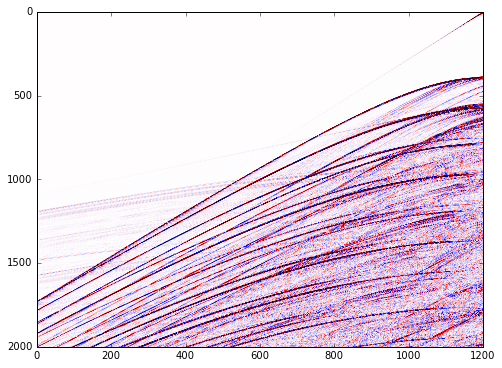

In [23]:
plt.figure(figsize=(8,6))
plt.imshow(nc.variables['Samples'][0,:,:].T,vmin=-0.01,vmax=0.01,cmap='seismic',aspect='auto')

Since the names of the dimensions and their values are available, we could attach these to the plots. There is, however, another Python package that makes this, and other tasks, much easier, which we will look at now.

### Accessing the data using xarray

An alternative package for working with NetCDF data is [`xarray`](http://xarray.pydata.org/). 

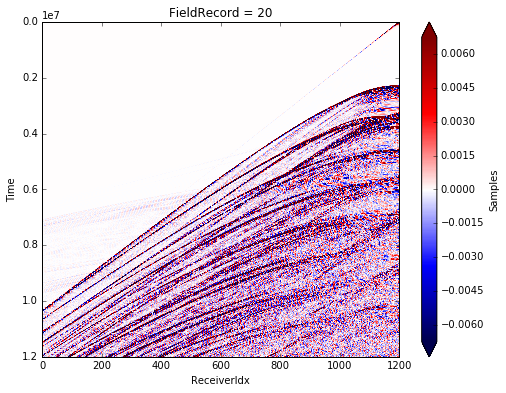

In [48]:
shots.close()
shots = xr.open_dataset('shots0001_0200_20.nc')
shots.Samples.isel(FieldRecord=0).squeeze().T.plot(figsize=(8,6), robust=True, cmap='seismic', yincrease=False)

We now automatically have informative axis and tick labels. The `robust` plotting option that I used clips the data between the 2nd and 98th percentiles to reduce the effect of outliers. I also used `.squeeze`, `.T` and `yincrease=False` to flip the data into the orientation typically used to display exploration seismic data. I could also have specified the dimensions to use for the x and y axes, as in the next example.

If we want to show something that has more than two dimensions, we can use faceting. Here is a plot of all of the shot gathers (field records) in the file.

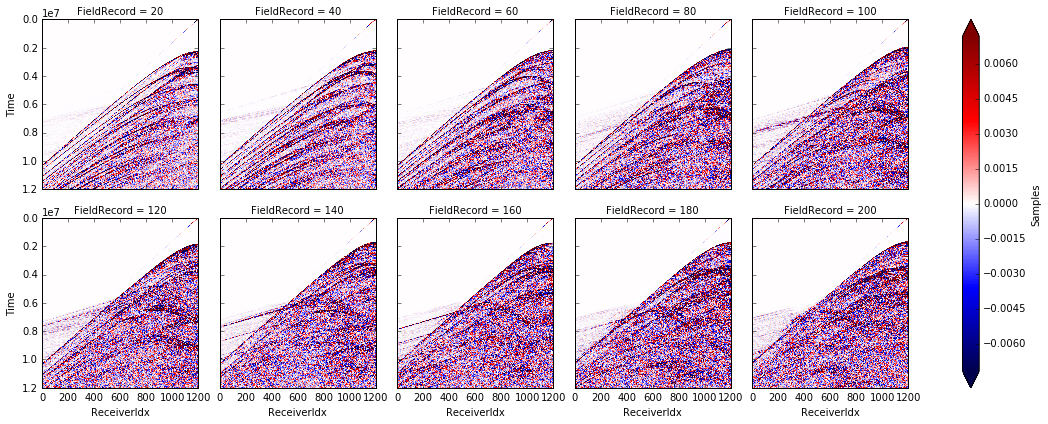

In [20]:
shots.Samples.plot(x='ReceiverIdx', y='Time', col='FieldRecord', col_wrap=5, robust=True, cmap='seismic', yincrease=False)

Plotting shot gathers uses contiguous data in this case, but we can just as easily plot any other slice of the data that we are interested in.

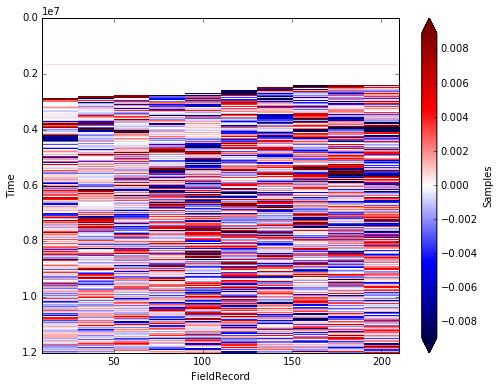

In [15]:
plt.figure(figsize=(8,6))
shots.Samples.isel(ReceiverIdx=1000).squeeze().T.plot.imshow(robust=True,cmap='seismic',yincrease=False)

This one shows the traces for the 1000th receiver in each shot gather.

We can also look at the header values. Let's take GroupX (the x position of the receiver) as an example.

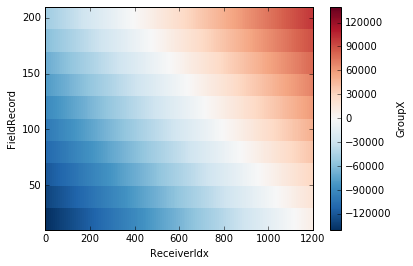

In [27]:
shots.GroupX.plot()

We can perform operations like calculating the mean of all traces where GroupX = 0.

In [76]:
shots.Samples.where(shots.GroupX==0).mean()

<xarray.DataArray ()>
array(-2.5427885930184857e-07)

If you have used [`pandas`](http://pandas.pydata.org/), you will know how convenient it is for working with tabular data. `Pandas` isn't ideal for multidimensional arrays, like seismic data, which is why `xarray` was developed. It provides many of the useful features of `pandas`, such as `groupby`.

In [24]:
shots.Samples.groupby('FieldRecord').mean()

<xarray.DataArray 'Samples' (FieldRecord: 10)>
array([  1.459018e-08,   5.579487e-08,  -5.082345e-08,   7.949281e-08,
        -6.190074e-08,   2.372765e-08,   1.385143e-08,   2.094364e-07,
        -9.181500e-08,   1.304281e-08])
Coordinates:
  * FieldRecord  (FieldRecord) int32 20 40 60 80 100 120 140 160 180 200

This example groups the data by FieldRecord, and then separately calculates the mean of each group. There are 10 results in the array - one for each shot gather.

`xarray` also understands that binary operations should be performed on arrays with matching dimensions (unless you force it to do otherwise). To demonstrate this, I add the first and last field records in the file, with the first one transposed (`.T`). If you did this with ordinary Numpy arrays, it would fail because the arrays are no longer the same shape. With `xarray`, cells are added based on their coordinates in (ReceiverIdx,Time) space, so transposing one array won't affect the result. This can help to make the coding of algorithms quite elegant.

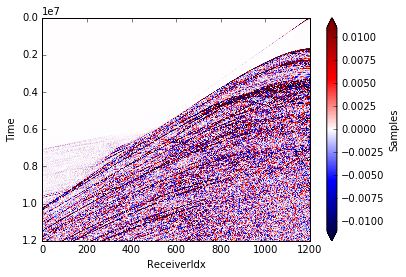

In [83]:
(shots.Samples.sel(FieldRecord=20).T + shots.Samples.sel(FieldRecord=200)).plot(x='ReceiverIdx', y='Time', robust=True, cmap='seismic', yincrease=False)

These examples have hopefully demonstrated how seismic data, stored in NetCDF4 format and accessed with `xarray`, can provide great flexibility while still remaining very readable and easy to use.

The feature of `xarray` that I find the most exciting, however, is its integration with [`dask`](http://dask.pydata.org/), a parallel computing library for Python. Since many seismic algorithms are highly parallelizable, they are well suited to `dask`. If we want to operate on different shot gathers in parallel, we would just chunk our file over the shot dimension.

In [91]:
shots.close()
shots = xr.open_dataset('shots0001_0200_20.nc', chunks={'FieldRecord': 1})
m = shots.Samples.mean(dim=['ReceiverIdx', 'Time'])
m.compute()

<xarray.DataArray 'Samples' (FieldRecord: 10)>
array([  1.459023e-08,   5.579501e-08,  -5.082270e-08,   7.949372e-08,
        -6.189935e-08,   2.372802e-08,   1.385100e-08,   2.094425e-07,
        -9.181294e-08,   1.304309e-08])
Coordinates:
  * FieldRecord  (FieldRecord) int32 20 40 60 80 100 120 140 160 180 200

In this example, I specified that I wanted one shot gather (field record) in each chunk. I then created a variable, `m`, derived from operations applied to the shot gathers. I only used one operation (calculating the mean of the trace data for each shot gather), but there could be multiple operations chained together. When I run `m.compute()`, the appropriate chunks will be loaded, in parallel, so that the tasks necessary to perform the operations that generate `m` can be performed. This means that I could apply an operation to each shot gather even if the whole file doesn't fit into the memory of my laptop, as only one chunk per core will be loaded at a time.

This has become especially interesting with the recent addition of `dask distributed` to `xarray`. Now you can launch the `dask distributed` scheduler on a cluster, and have the tasks run in parallel over the nodes. You could write an RTM or FWI code in Python, with the convenience of `xarray`, and have it run in parallel on your cluster.

I hope this has highlighted the benefits of switching from SEG-Y to NetCDF, a file format with a large userbase, flexibility, and support for multidimensional data.
For further discussion of SEG-Y alternatives, see [Software Underground's X Seismic Data Format notes](https://github.com/softwareunderground/xsdf).